## Step 1:  Data Preparation

In [5]:
import librosa
import os
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

DATASET_PATH = "DATASET FINAL/train"
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 16000 # 1 sec. of audio


def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):

    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        dirnames.sort()

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path, sr = 16000)


                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))
                else:                    
                    os.remove(file_path)

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    preprocess_dataset(DATASET_PATH, JSON_PATH)


Processing: 'train\blow horn'
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_01.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_02.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_03.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_04.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_05.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_06.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_07.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_08.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_09.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_10.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_11.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_12.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_13.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_14.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_15.wav: 0
DATASET FINAL/train\blow horn\20761A04D2_BlowHorn_16.wav: 0
DATASET F

## Step 2: Model Building and Training

Training sets loaded!
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 11, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 30, 11, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 4, 32)         18464     
                                                                 
 batch_normalization_7 (Bat  (None, 13, 4, 32)         128       
 chNormalization)                                                
                                

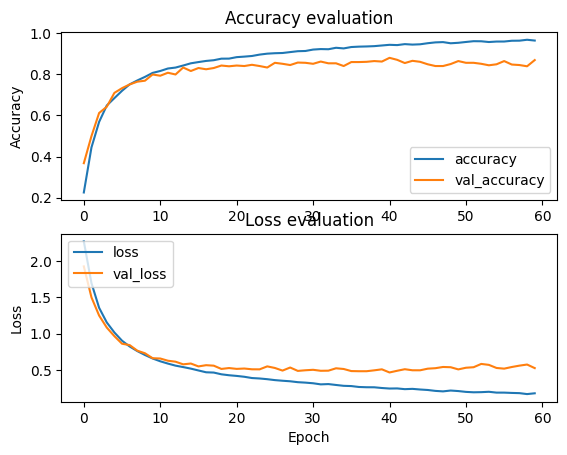

65/65 [==============================] - 0s 6ms/step - loss: 0.5534 - accuracy: 0.8664

Test loss: 0.5533565878868103, test accuracy: 86.64085268974304
65/65 [==============================] - 1s 6ms/step - loss: 0.3858 - accuracy: 0.9138
Test loss: 0.3858105540275574
Test accuracy: 0.9138431549072266
65/65 [==============================] - 0s 5ms/step
Overall Accuracy: 91.38%


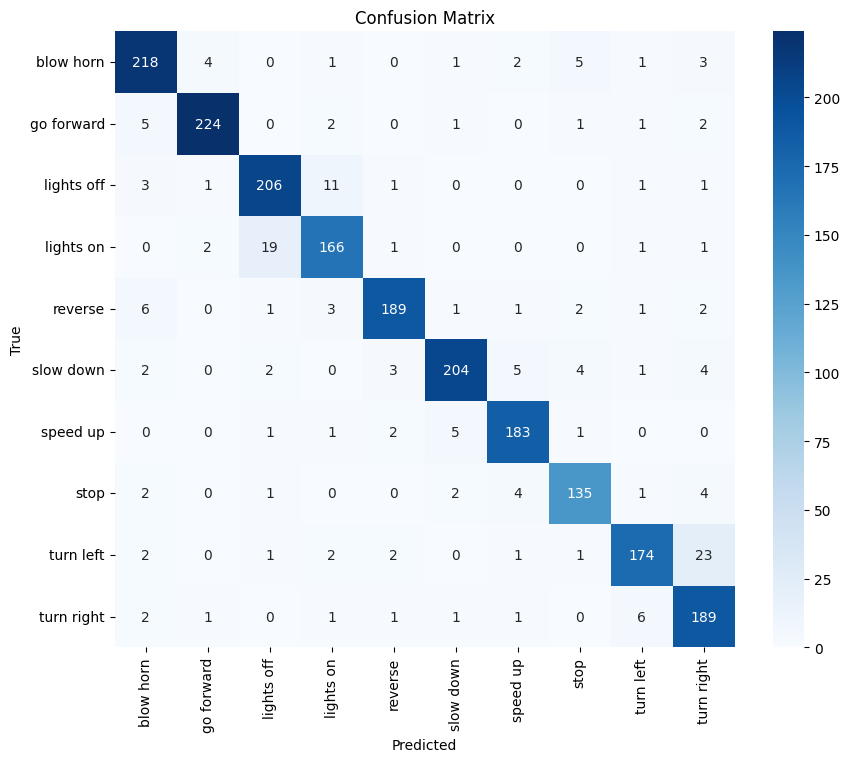

In [7]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

DATA_PATH = "data.json"
SAVED_MODEL_PATH = "speech_model01.h5"
EPOCHS = 60
BATCH_SIZE = 10
PATIENCE = 5
LEARNING_RATE = 0.0001
class_labels = ["blow horn", "go forward", "lights off", "lights on", "reverse","slow down", "speed up","stop","turn left", "turn right"]  

def load_data(data_path):
    # Loads training dataset from json file
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

def prepare_dataset(data_path, test_size=0.2, validation_size=0.1):
    # Creates train, validation, and test sets
    X, y = load_data(data_path)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    # Build neural network using keras
    model = tf.keras.models.Sequential()

    #convolution layers
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    #fully connected layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    model.add(tf.keras.layers.Dense(len(class_labels), activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimiser, loss=loss, metrics=["accuracy"])
    model.summary()
    return model

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, y_validation), callbacks=[earlystop_callback])
    return history

def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper left")
    axs[1].set_title("Loss evaluation")

    plt.show()

def main():
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    plot_history(history)

    # Evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # Load your trained model
    model = tf.keras.models.load_model(SAVED_MODEL_PATH)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)

    # Predict labels for the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate the overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot a heatmap for the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()


## Step 3: Testing the Model

In [8]:
import tensorflow as tf
import librosa
import numpy as np

# Load your pre-trained CNN model
model = tf.keras.models.load_model('speech_model01.h5')

# Load the audio file for prediction
audio_file = "DATASET FINAL/test/slow down/23CSMLE02_slowdown_12.wav"
audio, sample_rate = librosa.load(audio_file, sr=16000)

# Preprocess the audio to match the model's input requirements
segment_length = 16000  # Fixed length for audio segments
if len(audio) > segment_length:
    audio = audio[:segment_length]
elif len(audio) < segment_length:
    audio = np.pad(audio, (0, segment_length - len(audio)))

# Extract Mel spectrogram features
num_mfcc=13
n_fft=2048
hop_length=512
mel_spectrogram = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
mel_spectrogram = mel_spectrogram.T  # Transpose the matrix if needed

# Reshape and prepare the data for prediction
input_data = mel_spectrogram[np.newaxis, ..., np.newaxis]

# Get the predicted probabilities for each class
predictions = model.predict(input_data)

# Define the mapping from class indices to command labels
class_mapping = {
    0: "blow horn",
    1: "go forward",
    2: "lights off",
    3: "lights on",
    4: "reverse",
    5: "slow down",
    6: "speed up",
    7: "stop",
    8: "turn left",
    9: "turn right"
    # Add more class mappings here
}

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted command label
predicted_command = class_mapping[predicted_class_index]

# Display the predicted command
print(f"Predicted Command: {predicted_command}")


1/1 [==============================] - 0s 75ms/step
Predicted Command: slow down


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Load an audio file
audio_file = "DATASET FINAL/test/slow down/23CSMLE02_slowdown_12.wav"
y, sr = librosa.load(audio_file)

# Generate time values for the x-axis
time = np.arange(0, len(y)) / sr

# Plot the audio signal
plt.figure(figsize=(8, 4))
plt.plot(time, y)
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an audio file
audio_file = "DATASET FINAL/test/slow down/23CSMLE02_slowdown_12.wav"
y, sr = librosa.load(audio_file)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Display the MFCCs
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='magma')
plt.colorbar()
plt.title('MFCC Features')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()


In [4]:
from cnn_block_visualizer import CNNBlockVisualizer  # Assuming the class is saved in a file named cnn_block_visualizer.py

# Define layer information based on the summary
layer_info = [
    ("conv2d_3", "Conv2D", (None, 30, 11, 64)),
    ("batch_normalization_3", "BatchNormalization", (None, 30, 11, 64)),
    ("max_pooling2d_3", "MaxPooling2D", (None, 15, 6, 64)),
    ("conv2d_4", "Conv2D", (None, 13, 4, 32)),
    ("batch_normalization_4", "BatchNormalization", (None, 13, 4, 32)),
    ("max_pooling2d_4", "MaxPooling2D", (None, 7, 2, 32)),
    ("conv2d_5", "Conv2D", (None, 6, 1, 32)),
    ("batch_normalization_5", "BatchNormalization", (None, 6, 1, 32)),
    ("max_pooling2d_5", "MaxPooling2D", (None, 3, 1, 32)),
    ("flatten_1", "Flatten", (None, 96)),
    ("dense_2", "Dense", (None, 64)),
    ("dropout_1", "Dropout", (None, 64)),
    ("dense_3", "Dense", (None, 455)),
]

# Create the visualizer
visualizer = CNNBlockVisualizer("speech_model01.h5", (None, 32, 32, 3), (None, 455))

# Add layers and connections based on the information
for name, layer_type, output_shape in layer_info:
    visualizer.add_layer(name, layer_type)

# Connect convolutional layers to subsequent layers (assuming standard connections)
prev_layer = None
for name, _, _ in layer_info:
    if name.startswith("conv2d"):
        if prev_layer:
            visualizer.connect_layers(prev_layer, name)
        prev_layer = name

# Connect remaining layers sequentially
for i in range(1, len(layer_info)):
    visualizer.connect_layers(layer_info[i-1][0], layer_info[i][0])

# Generate the image
visualizer.generate_image("pre_trained_model.png")

ModuleNotFoundError: No module named 'cnn_block_visualizer'

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Load your pre-trained CNN model
model = tf.keras.models.load_model('speech_model01.h5')

# Visualize the model architecture and save the image
plot_model(model, to_file='model_architecture.png', show_shapes=True)


TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

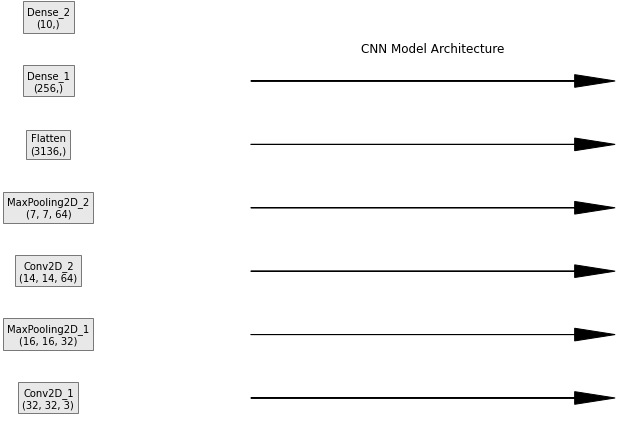

In [6]:
import matplotlib.pyplot as plt

# Define the layers of your CNN model
layer_info = [
    ("Conv2D_1", (32, 32, 3)),
    ("MaxPooling2D_1", (16, 16, 32)),
    ("Conv2D_2", (14, 14, 64)),
    ("MaxPooling2D_2", (7, 7, 64)),
    ("Flatten", (3136,)),
    ("Dense_1", (256,)),
    ("Dense_2", (10,))
]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each layer as a block with its output shape
for i, (name, shape) in enumerate(layer_info, 1):
    plt.text(0, i, f"{name}\n{shape}", va='center', ha='center', bbox=dict(facecolor='lightgray', alpha=0.5))

# Add arrows to indicate connections between layers
for i in range(len(layer_info) - 1):
    plt.arrow(0.5, i + 1, 0.8, 0, head_width=0.2, head_length=0.1, fc='k', ec='k')

# Set plot attributes
plt.axis('off')
plt.title("CNN Model Architecture")
plt.tight_layout()

# Save or display the plot
plt.savefig("cnn_model_architecture.png")
plt.show()
